In [1]:
import os
import numpy as np
import pandas as pd
import uproot as ur

import sys
sys.path.append('../')
from jupyter_utils import *

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()
pd.set_option('display.max_rows', None)

from matplotlib.patches import PathPatch
from matplotlib.path import Path

# Lauren's colors
L_colors = ['red', 'darkorange', 'limegreen', 'green', 'deepskyblue', 'blue', 'black']
L_linestyles = ['solid', 'dashed']
L_markers = ['s', '^', 'v', 'd', 'P', "X", "*"]

In [2]:
# closure test? i.e. there is truth pythia data somewhere to compare to
closure = True

# define binnings
n_bins = [20, 20, 6] # WARNING RooUnfold seg faults if too many bins used
binning = [np.logspace(-5,0,n_bins[0]+1), \
            np.logspace(-4,0,n_bins[1]+1), \
            np.array([5, 20, 40, 60, 80, 100, 150]).astype(float) ]
print(binning[0])
print(binning[1])
bincenters = [ get_log_bincenters(binning[0]), get_log_bincenters(binning[1]), get_lin_bincenters(binning[2]) ]
binwidths = [ get_binwidths(a) for a in binning ]

labels = ["energy weight", "$R_L$", "jet $p_T$"]

n_iter = 5

[1.00000000e-05 1.77827941e-05 3.16227766e-05 5.62341325e-05
 1.00000000e-04 1.77827941e-04 3.16227766e-04 5.62341325e-04
 1.00000000e-03 1.77827941e-03 3.16227766e-03 5.62341325e-03
 1.00000000e-02 1.77827941e-02 3.16227766e-02 5.62341325e-02
 1.00000000e-01 1.77827941e-01 3.16227766e-01 5.62341325e-01
 1.00000000e+00]
[1.00000000e-04 1.58489319e-04 2.51188643e-04 3.98107171e-04
 6.30957344e-04 1.00000000e-03 1.58489319e-03 2.51188643e-03
 3.98107171e-03 6.30957344e-03 1.00000000e-02 1.58489319e-02
 2.51188643e-02 3.98107171e-02 6.30957344e-02 1.00000000e-01
 1.58489319e-01 2.51188643e-01 3.98107171e-01 6.30957344e-01
 1.00000000e+00]


In [3]:
# file defs, hist imports

f_unfolded = ur.open("./unfolded_fr_new.root")
f_preunfold = ur.open("./preunfold_fr_new.root")

# Data, reco [theta_unknown_S]
h3_raw = f_preunfold["raw"]
h1_raw = f_preunfold["raw1D"]

# MC, reco [theta0_S]
h3_reco = f_preunfold["reco"]
h1_true = f_preunfold["reco1D"]

# MC, true [theta0_G]
h3_gen = f_preunfold["gen"]
h1_gen = f_preunfold["gen1D"]

# Data, true [theta_unknown_G]
# NO TRUE DATA HERE

h3_unfolded = []
#h1_unfolded = [] TODO add in h1 unfolded support
for i in range(1,n_iter+1):
    h3_unfolded.append(f_unfolded["Baysian_Unfoldediter{}".format(i)])


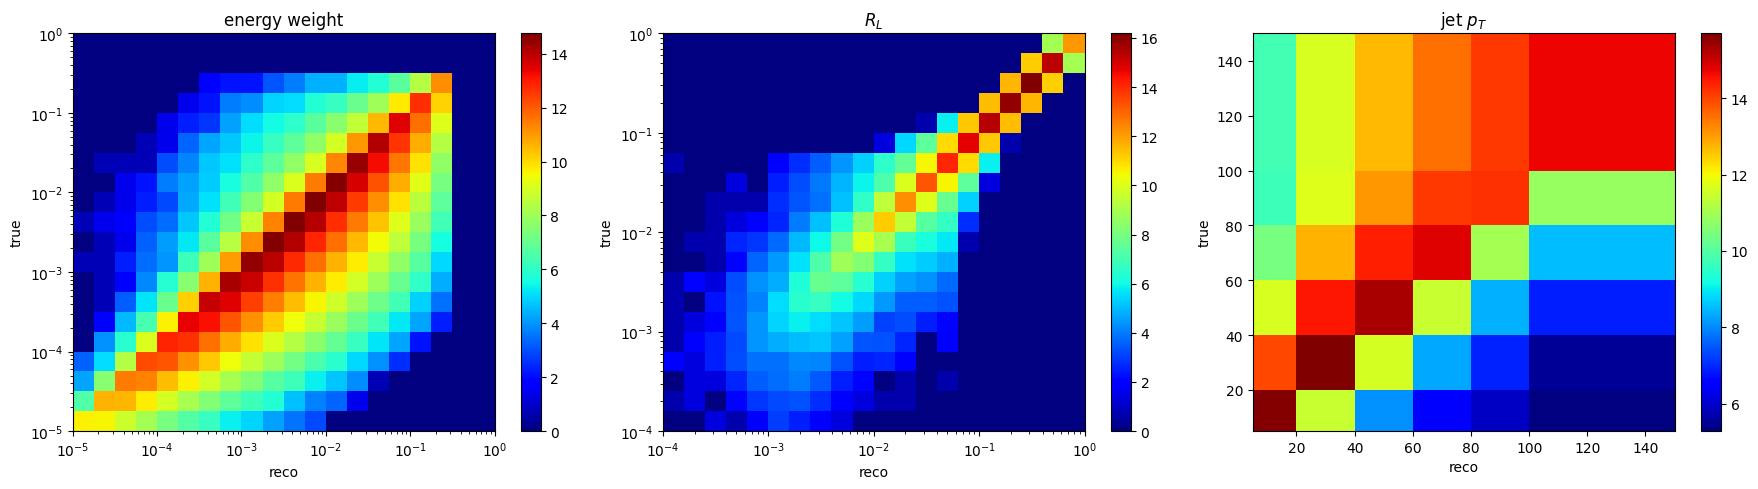

In [4]:
def FindBin(binx, biny, binz):
    assert binx < n_bins[0] and biny < n_bins [1] and binz < n_bins[2] \
            and 0 <= binx and 0 <= biny and 0 <= binz
    return binx + n_bins[0]*(biny + n_bins[1]*binz)

def FindIndex(bin_n):
    binz = bin_n // (n_bins[0] * n_bins[1])
    bin_n -= binz * (n_bins[0] * n_bins[1])

    biny = bin_n // n_bins[0]
    binx = bin_n % n_bins[0]

    return binx, biny, binz
    

matrix = f_unfolded["matrix"].values()
matrix1D = f_unfolded["matrix1D"].values()

[matrixx, matrixy, matrixz] = [np.zeros((n_bins[i], n_bins[i])) for i in range(3)]

N = n_bins[0]*n_bins[1]*n_bins[2]

for i in range(n_bins[0]):
    for j in range(n_bins[1]):
        for k in range(n_bins[2]):

            reco_bin = FindBin(i, j, k)
            for m in range(N):
                
                binx, biny, binz = FindIndex(m)
                bincontent = matrix[reco_bin][m]

                matrixx[i][binx] += bincontent
                matrixy[j][biny] += bincontent
                matrixz[k][binz] += bincontent

matricies = [matrixx, matrixy, matrixz]

# print response matricies

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i in range(3):
    ax = axes[i]

    # Plot histograms
    #ax.imshow(matrix.values(), origin='lower', extent=[binning[0][0], binning[0][-1], binning[0][0], binning[0][-1]], cmap='viridis')
    h = matricies[i]
    plot = ax.pcolormesh(binning[i], binning[i], np.log(h, out=np.zeros_like(h), where=(h!=0)).T, cmap='jet')
    ax.set_title(labels[i])
    ax.set_xlabel('reco')
    ax.set_ylabel('true')

    if i in [0,1]:
        ax.set_xscale('log')
        ax.set_yscale('log')

    fig.colorbar(plot)


# Show plot
plt.tight_layout()
plt.show()

In [8]:
proj = lambda a : np.array([projectionX(a.values()), projectionY(a.values()), projectionZ(a.values())])
proj_err = lambda a : np.array([projectionX(a.errors()), projectionY(a.errors()), projectionZ(a.errors())])

theta0_G = proj(h3_gen)
theta0_S = proj(h3_reco)
theta_unknown_S = proj(h3_raw)

theta_unfolded = [proj(a) for a in h3_unfolded]

theta0_G_err = proj_err(h3_gen)
theta0_S_err = proj_err(h3_reco)
theta_unknown_S_err = proj_err(h3_raw)

theta_unfolded_err = [proj_err(a) for a in h3_unfolded]

matrixify = lambda A : projectionXY(A.values()).T
matrixify_err = lambda A: projectionXY(A.errors()).T

U_unfolded = [matrixify(A) for A in h3_unfolded]
U_unfolded_err = [matrixify_err(A) for A in h3_unfolded]

print(theta0_G)


[array([  98710.,  233834.,  487170.,  916378., 1579578., 2491048.,
        3610440., 4829466., 5957948., 6762398., 7036944., 6663534.,
        5688764., 4285586., 2783766., 1489388.,  591148.,  120858.,
              0.,       0.])
 array([1.8600000e+02, 3.1800000e+02, 4.9400000e+02, 9.6600000e+02,
        1.8440000e+03, 3.5020000e+03, 7.2660000e+03, 1.5792000e+04,
        3.7454000e+04, 8.7300000e+04, 2.0953400e+05, 4.8968000e+05,
        1.0949520e+06, 2.2934500e+06, 4.4515120e+06, 7.9736060e+06,
        1.3096210e+07, 1.7512662e+07, 7.9322060e+06, 4.1802400e+05])
 array([10940930., 12170360., 10323968.,  7845732.,  5693788.,  8652180.])]


/tmp/ipykernel_1436487/1209755565.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  proj = lambda a : np.array([projectionX(a.values()), projectionY(a.values()), projectionZ(a.values())])
/tmp/ipykernel_1436487/1209755565.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  proj_err = lambda a : np.array([projectionX(a.errors()), projectionY(a.errors()), projectionZ(a.errors())])


In [18]:
# get total number of jets, manually inputted from 1D jet unfolding

N_jets = 1024492
N_jets_err = 1070

(3,)
[1.8600000e+02 3.1800000e+02 4.9400000e+02 9.6600000e+02 1.8440000e+03
 3.5020000e+03 7.2660000e+03 1.5792000e+04 3.7454000e+04 8.7300000e+04
 2.0953400e+05 4.8968000e+05 1.0949520e+06 2.2934500e+06 4.4515120e+06
 7.9736060e+06 1.3096210e+07 1.7512662e+07 7.9322060e+06 4.1802400e+05]
[1.00000000e-04 1.58489319e-04 2.51188643e-04 3.98107171e-04
 6.30957344e-04 1.00000000e-03 1.58489319e-03 2.51188643e-03
 3.98107171e-03 6.30957344e-03 1.00000000e-02 1.58489319e-02
 2.51188643e-02 3.98107171e-02 6.30957344e-02 1.00000000e-01
 1.58489319e-01 2.51188643e-01 3.98107171e-01 6.30957344e-01
 1.00000000e+00]
21
(array([1.8600000e+02, 3.1800000e+02, 4.9400000e+02, 9.6600000e+02,
       1.8440000e+03, 3.5020000e+03, 7.2660000e+03, 1.5792000e+04,
       3.7454000e+04, 8.7300000e+04, 2.0953400e+05, 4.8968000e+05,
       1.0949520e+06, 2.2934500e+06, 4.4515120e+06, 7.9736060e+06,
       1.3096210e+07, 1.7512662e+07, 7.9322060e+06, 4.1802400e+05]), array([1.00000000e-04, 1.58489319e-04, 2.511886

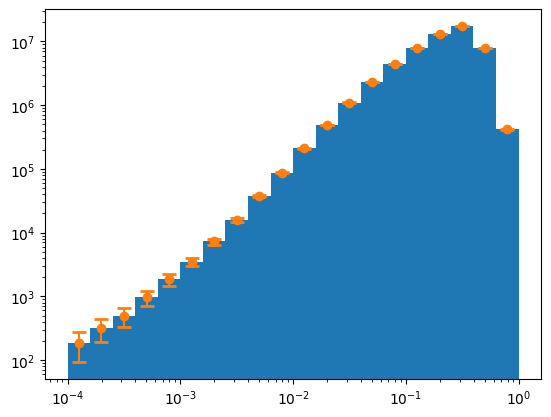

In [19]:
print(theta0_G.shape)
print(theta0_G[1])
print(binning[1])
print(len(binning[1]))

print(plt.hist(binning[1][:-1], binning[1], weights=theta0_G[1]))
print(len(binning[1][:-1]))
print(len(theta0_G_err[1]))
plt.errorbar(bincenters[1], theta0_G[1], yerr=theta0_G_err[1], capsize=5, capthick=2, fmt='o', linestyle="None")
plt.yscale('log')
plt.xscale('log')
plt.show()

In [20]:
for iteration in range(n_iter):
    print(theta_unfolded[iteration][1])

print()

[5.36305818e+01 1.59773527e+02 2.74758315e+02 5.08436915e+02
 1.36443141e+03 2.29540462e+03 4.31477756e+03 8.26521431e+03
 1.94127910e+04 4.44325912e+04 9.97660661e+04 2.22600065e+05
 5.19907228e+05 1.23292447e+06 2.95111055e+06 6.96264300e+06
 1.54961407e+07 2.71848039e+07 1.51351690e+07 7.89100132e+05]
[6.65941545e+01 1.69909805e+02 2.97500647e+02 4.74932177e+02
 1.24342617e+03 2.38618762e+03 4.29436026e+03 8.01822791e+03
 1.96973559e+04 4.60390593e+04 1.03203149e+05 2.26109504e+05
 5.25507192e+05 1.24624475e+06 2.97766981e+06 7.02384387e+06
 1.56527693e+07 2.75044500e+07 1.54903785e+07 8.37147797e+05]
[7.79583141e+01 1.85818499e+02 3.14229195e+02 4.41229935e+02
 1.15520042e+03 2.37232782e+03 4.25046692e+03 7.80616063e+03
 1.94099615e+04 4.63895954e+04 1.04064716e+05 2.26778570e+05
 5.28216035e+05 1.25131063e+06 2.98906723e+06 7.04851844e+06
 1.57044639e+07 2.75781768e+07 1.55391008e+07 8.41264397e+05]
[9.18936460e+01 2.04469882e+02 3.34930259e+02 4.20710224e+02
 1.11776872e+03 2.378

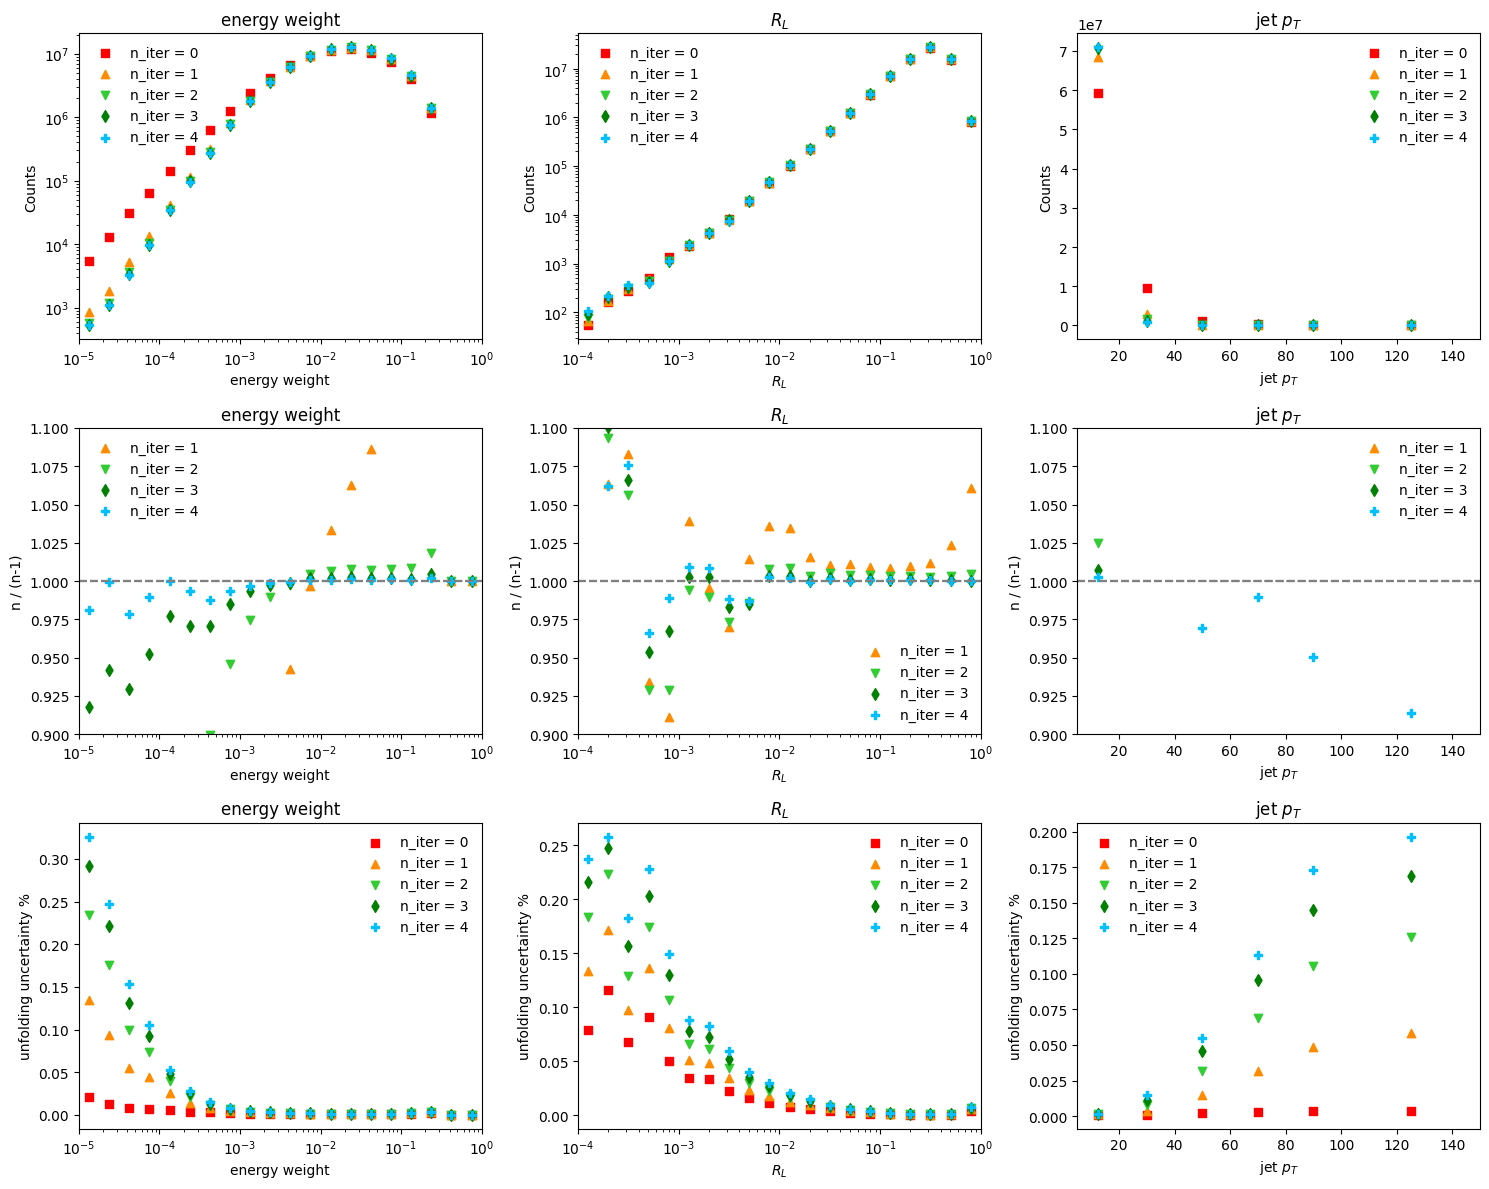

In [23]:
############################## UNFOLDED DISTRIBUTIONS ############################
# individual distros

it = 5

fig, axes = plt.subplots(3, 3, figsize=(15,12))

# ROW 1: raw distributions
for i in range(3):
    ax = axes[0, i]

    for iteration in range(it):
        ax.scatter(bincenters[i], theta_unfolded[iteration][i],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
        ax.set_ylabel("Counts")

        #ax.errorbar(bincenters[i], theta_unfolded[iteration][:,i], yerr=theta_unfolded_err[iteration][:,i], capsize=5, capthick=2, fmt='o', linestyle="None", color=L_colors[iteration])
        
        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
            ax.set_yscale('log')
            #ax.set_ylim([0.1, 4E8])
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


# ROW 2: convergence plot (n / n - 1)
for i in range(3):
    ax = axes[1, i]

    for iteration in range(1,it):
    
        yvals = safe_divide(theta_unfolded[iteration][i] , theta_unfolded[iteration-1][i], filler=1)
        ax.scatter(bincenters[i], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

        ax.hlines(y=1, xmin=binning[i][0], xmax=binning[i][len(binning[i])-1], color='grey', linestyle='--')

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("n / (n-1)")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
        ax.set_ylim([0.9, 1.1])
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


# ROW 3: statistical error %
for i in range(3):
    ax = axes[2, i]

    for iteration in range(it):
        
        yvals = safe_divide(theta_unfolded_err[iteration][i], theta_unfolded[iteration][i])
        ax.scatter(bincenters[i], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

        ax.set_title(labels[i])
        ax.set_xlabel(labels[i])
        ax.set_ylabel("unfolding uncertainty %")
        ax.legend(frameon=False)

        if i in [0, 1]:
            ax.set_xscale('log')
        ax.set_xlim([binning[i][0], binning[i][len(binning[i])-1]])


fig.tight_layout()
plt.show()

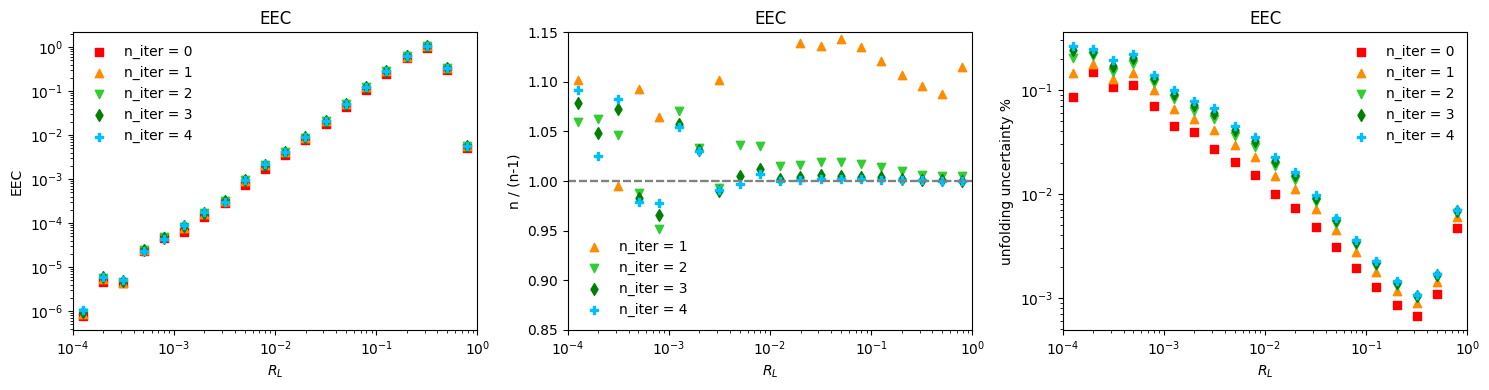

In [24]:
############################## UNFOLDED DISTRIBUTIONS ############################
# EEC distros

it = 5

fig, axes = plt.subplots(1, 3, figsize=(15,4))

# EEC weight calculation:
# w_n = U * b, U is matrixfied RL-energy weight 2D histogram, b is bincenters of energy weights

unfolded_EEC = np.array([[np.dot(col, bincenters[0]) for col in U_unfolded[iteration]] for iteration in range(len(theta_unfolded))]) / N_jets
unfolded_EEC_err = np.array([[np.dot(col, bincenters[0]) for col in U_unfolded_err[iteration]] for iteration in range(len(theta_unfolded))]) / N_jets

# TODO propagate error from N_jets here, i dont wanna do ittttt

# COL 1: raw EEC distribution WITH relative error over data, true underneath
ax = axes[0]

rl_lims = ax.set_xlim([binning[1][0], binning[1][len(binning[1])-1]])

for iteration in range(it):

    ax.scatter(bincenters[1], unfolded_EEC[iteration],color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)
    ax.set_ylabel("EEC")
    
    ax.set_title("EEC")
    ax.set_xlabel(labels[1])

    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)
    
# COL 2: convergence plot (n / n - 1)
ax = axes[1]

for iteration in range(1,it):

    yvals = safe_divide(unfolded_EEC[iteration], unfolded_EEC[iteration-1], filler=1)
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.hlines(y=1, xmin=binning[1][0], xmax=binning[1][len(binning[1])-1], color='grey', linestyle='--')

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("n / (n-1)")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_ylim([0.85, 1.15])
    ax.set_xlim(rl_lims)


# COL 3: statistical error %
ax = axes[2]

for iteration in range(it):
    
    yvals = safe_divide(unfolded_EEC_err[iteration], unfolded_EEC[iteration])
    ax.scatter(bincenters[1], yvals, color=L_colors[iteration],marker=L_markers[iteration],label="n_iter = {}".format(iteration),lw=1)

    ax.set_title("EEC")
    ax.set_xlabel(labels[1])
    ax.set_ylabel("unfolding uncertainty %")
    ax.legend(frameon=False)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(rl_lims)


fig.tight_layout()
plt.show()
